# Algoritmo GRASP aplicado ao Problema do Caixeiro Viajante

Este notebook explica o algoritmo GRASP (Greedy Randomized Adaptive Search Procedure) e sua aplicação na resolução do Problema do Caixeiro Viajante (TSP).

## 1. Introdução ao Algoritmo GRASP

O GRASP (Greedy Randomized Adaptive Search Procedure) é uma metaheurística de otimização combinatória desenvolvida na década de 1980 por Feo e Resende. É um método multi-start que combina elementos construtivos e de busca local.

### Características principais do GRASP:

1. **Iterativo**: Executa múltiplas iterações independentes e retorna a melhor solução encontrada.

2. **Duas fases em cada iteração**:
   - **Fase de construção**: Constrói uma solução inicial de forma semi-gulosa e aleatorizada.
   - **Fase de busca local**: Melhora a solução inicial através de movimentos de busca local.

3. **Lista Restrita de Candidatos (RCL)**: Um dos conceitos-chave do GRASP é a RCL, que contém elementos candidatos promissores selecionados com base em algum critério guloso.

### Pseudocódigo geral do GRASP:

```
função GRASP(max_iteracoes, alpha):
    melhor_solucao = NULL
    
    para i = 1 até max_iteracoes:
        solucao = Construcao_Gulosa_Aleatorizada(alpha)
        solucao = Busca_Local(solucao)
        
        se solucao é melhor que melhor_solucao:
            melhor_solucao = solucao
    
    retornar melhor_solucao
```

onde:
- `max_iteracoes`: número máximo de iterações GRASP
- `alpha`: parâmetro de controle da aleatoriedade (0 ≤ alpha ≤ 1)

## 2. O Problema do Caixeiro Viajante (TSP)

O Problema do Caixeiro Viajante (TSP) é um dos problemas mais estudados em otimização combinatória. A descrição formal é:

- Dado um conjunto de cidades e as distâncias entre cada par de cidades
- Encontrar a rota mais curta que visita cada cidade exatamente uma vez e retorna à cidade de origem

Este é um problema NP-difícil, o que significa que não existem algoritmos exatos eficientes para instâncias grandes.

## 3. Implementação do GRASP para o TSP

Vamos implementar o algoritmo GRASP para resolver o Problema do Caixeiro Viajante (TSP), começando com as bibliotecas necessárias e a geração de dados para o problema.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import List, Tuple, Dict, Set

# Define seed for reproducibility
np.random.seed(42)
random.seed(42)

### 3.1. Geração de Dados do Problema

Vamos gerar cidades aleatórias em um plano bidimensional e calcular a matriz de distâncias entre elas.

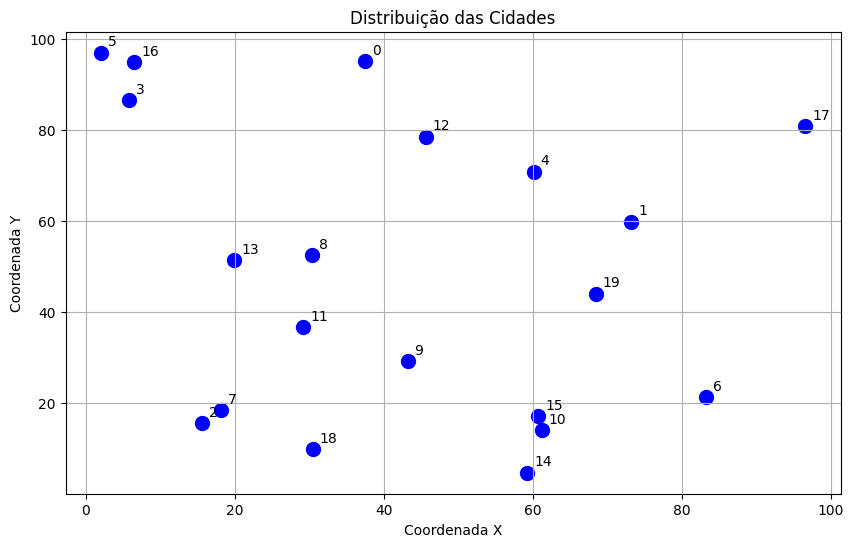

In [2]:
def generate_cities(n_cities: int, x_max: int = 100, y_max: int = 100) -> np.ndarray:
    """
    Gera coordenadas aleatórias para cidades em um plano bidimensional.
    
    Args:
        n_cities: Número de cidades
        x_max: Valor máximo para coordenada x
        y_max: Valor máximo para coordenada y
        
    Returns:
        Um array de coordenadas (x, y) para cada cidade
    """
    return np.random.rand(n_cities, 2) * np.array([x_max, y_max])

def calculate_distance_matrix(cities: np.ndarray) -> np.ndarray:
    """
    Calcula a matriz de distâncias euclidianas entre cidades.
    
    Args:
        cities: Array de coordenadas (x, y) para cada cidade
        
    Returns:
        Matriz de distâncias entre todas as cidades
    """
    n_cities = cities.shape[0]
    dist_matrix = np.zeros((n_cities, n_cities))
    
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                # Distância euclidiana
                dist_matrix[i, j] = np.sqrt(np.sum((cities[i] - cities[j])**2))
    
    return dist_matrix

# Gerar dados para o problema
n_cities = 20
cities = generate_cities(n_cities)
dist_matrix = calculate_distance_matrix(cities)

# Visualizar as cidades geradas
plt.figure(figsize=(10, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
for i, (x, y) in enumerate(cities):
    plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')
plt.title("Distribuição das Cidades")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(True)
plt.show()

### 3.2. Avaliação de Soluções

Precisamos de uma função para calcular o comprimento total de uma rota (solução para o TSP).

In [3]:
def evaluate_solution(solution: List[int], dist_matrix: np.ndarray) -> float:
    """
    Calcula o comprimento total de uma rota.
    
    Args:
        solution: Lista de índices de cidades na ordem de visita
        dist_matrix: Matriz de distâncias entre cidades
        
    Returns:
        Comprimento total da rota
    """
    total_distance = 0
    n = len(solution)
    
    for i in range(n):
        from_city = solution[i]
        to_city = solution[(i + 1) % n]  # Volta para a primeira cidade ao final
        total_distance += dist_matrix[from_city, to_city]
    
    return total_distance

### 3.3. Fase de Construção Gulosa Aleatorizada

Nesta fase, construímos uma solução inicial usando uma abordagem gulosa aleatorizada. O parâmetro `alpha` controla o nível de aleatoriedade.

In [4]:
def greedy_randomized_construction(dist_matrix: np.ndarray, alpha: float = 0.3) -> List[int]:
    """
    Constrói uma solução usando a abordagem gulosa aleatorizada do GRASP.
    
    Args:
        dist_matrix: Matriz de distâncias entre cidades
        alpha: Parâmetro de aleatoriedade (0 <= alpha <= 1)
            - alpha = 0: Construção completamente gulosa
            - alpha = 1: Construção completamente aleatória
            
    Returns:
        Uma solução (rota) para o TSP
    """
    n_cities = dist_matrix.shape[0]
    solution = [random.randint(0, n_cities - 1)]  # Inicia em uma cidade aleatória
    unvisited = set(range(n_cities)) - {solution[0]}
    
    # Construir a rota adicionando uma cidade por vez
    while unvisited:
        current_city = solution[-1]
        
        # Calcular custo de inserção para cada cidade não visitada
        candidates = []
        for next_city in unvisited:
            cost = dist_matrix[current_city, next_city]
            candidates.append((next_city, cost))
        
        # Ordenar candidatos pelo custo
        candidates.sort(key=lambda x: x[1])
        
        # Determinar o tamanho da RCL (Lista Restrita de Candidatos)
        rcl_size = max(1, int(alpha * len(candidates)))
        
        # Selecionar aleatoriamente uma cidade da RCL
        next_city = candidates[random.randint(0, rcl_size - 1)][0]
        
        # Adicionar à solução e remover das não visitadas
        solution.append(next_city)
        unvisited.remove(next_city)
    
    return solution

### 3.4. Fase de Busca Local

Na busca local, tentamos melhorar a solução atual através de pequenas modificações. Vamos implementar o movimento de troca 2-opt, que inverte um segmento da rota.

In [5]:
def two_opt_swap(route: List[int], i: int, j: int) -> List[int]:
    """
    Realiza uma troca 2-opt na rota, invertendo o segmento entre as posições i e j.
    
    Args:
        route: A rota atual
        i, j: Índices para a troca
        
    Returns:
        Nova rota após a troca
    """
    # Cria uma nova rota mantendo a ordem até o índice i-1
    # Inverte o segmento entre i e j
    # Mantém o restante da rota igual
    new_route = route[:i] + route[i:j+1][::-1] + route[j+1:]
    return new_route

def local_search(solution: List[int], dist_matrix: np.ndarray) -> List[int]:
    """
    Aplica busca local usando o movimento 2-opt para melhorar a solução.
    
    Args:
        solution: Solução inicial
        dist_matrix: Matriz de distâncias entre cidades
        
    Returns:
        Solução melhorada após a busca local
    """
    n = len(solution)
    improved = True
    best_solution = solution.copy()
    best_distance = evaluate_solution(best_solution, dist_matrix)
    
    # Continue até não encontrar mais melhorias
    while improved:
        improved = False
        
        # Tenta todas as possíveis trocas 2-opt
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # Realizar a troca 2-opt
                new_solution = two_opt_swap(best_solution, i, j)
                new_distance = evaluate_solution(new_solution, dist_matrix)
                
                # Se a nova solução for melhor, atualiza
                if new_distance < best_distance:
                    best_solution = new_solution
                    best_distance = new_distance
                    improved = True
                    break  # Primeira melhoria encontrada
            
            if improved:
                break
    
    return best_solution

### 3.5. Algoritmo GRASP Completo

Agora, integramos todas as partes em um algoritmo GRASP completo.

In [6]:
def grasp_tsp(dist_matrix: np.ndarray, max_iterations: int = 50, alpha: float = 0.3) -> Tuple[List[int], float]:
    """
    Algoritmo GRASP para o Problema do Caixeiro Viajante.
    
    Args:
        dist_matrix: Matriz de distâncias entre cidades
        max_iterations: Número máximo de iterações
        alpha: Parâmetro de aleatoriedade na fase construtiva
        
    Returns:
        Tuple contendo a melhor solução encontrada e seu custo
    """
    best_solution = None
    best_distance = float('inf')
    iteration_costs = []
    
    for iteration in range(max_iterations):
        # Fase 1: Construção gulosa aleatorizada
        solution = greedy_randomized_construction(dist_matrix, alpha)
        
        # Avaliar a solução construída
        distance_before_ls = evaluate_solution(solution, dist_matrix)
        
        # Fase 2: Busca local
        solution = local_search(solution, dist_matrix)
        
        # Avaliar a solução após busca local
        distance = evaluate_solution(solution, dist_matrix)
        iteration_costs.append(distance)
        
        # Atualizar a melhor solução, se necessário
        if distance < best_distance:
            best_solution = solution.copy()
            best_distance = distance
            print(f"Iteração {iteration+1}: Nova melhor solução com distância {best_distance:.2f}")
    
    return best_solution, best_distance, iteration_costs

## 4. Executando o Algoritmo GRASP para o TSP

Agora vamos executar o algoritmo e visualizar os resultados.

In [7]:
# Executar o algoritmo GRASP
start_time = time.time()
best_solution, best_distance, iteration_costs = grasp_tsp(
    dist_matrix, 
    max_iterations=50, 
    alpha=0.3
)
execution_time = time.time() - start_time

print(f"\nGRASP completado em {execution_time:.2f} segundos")
print(f"Melhor solução: {best_solution}")
print(f"Melhor distância: {best_distance:.2f}")

Iteração 1: Nova melhor solução com distância 386.43
Iteração 5: Nova melhor solução com distância 386.43

GRASP completado em 0.30 segundos
Melhor solução: [1, 19, 6, 14, 10, 15, 9, 18, 2, 7, 11, 8, 13, 3, 5, 16, 0, 12, 4, 17]
Melhor distância: 386.43


### 4.1. Visualização da Melhor Rota

Vamos visualizar a melhor rota encontrada pelo algoritmo GRASP.

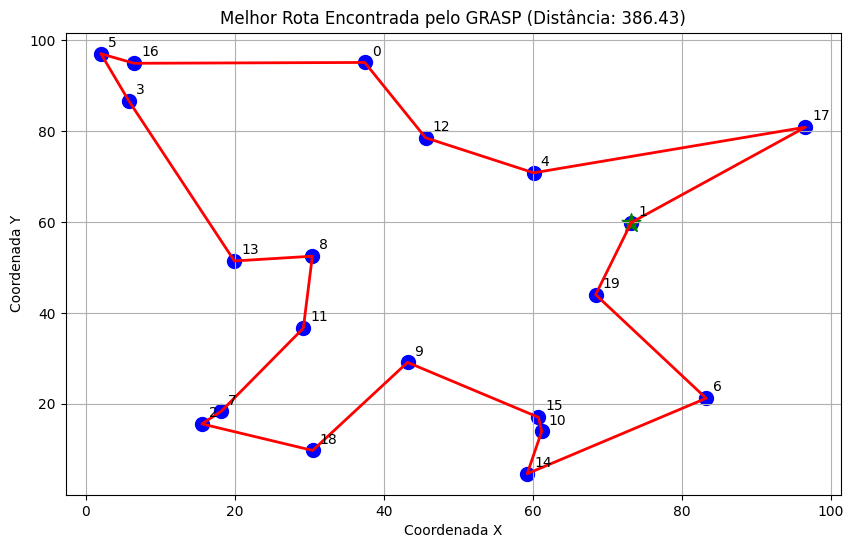

In [8]:
def plot_route(cities: np.ndarray, route: List[int], title: str):
    """
    Plota uma rota em um mapa de cidades.
    
    Args:
        cities: Coordenadas das cidades
        route: Ordem de visita das cidades
        title: Título do gráfico
    """
    plt.figure(figsize=(10, 6))
    
    # Plotar as cidades
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
    
    # Adicionar rótulos às cidades
    for i, (x, y) in enumerate(cities):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')
    
    # Plotar a rota
    route_coords = cities[route + [route[0]]]  # Adiciona o retorno à primeira cidade
    plt.plot(route_coords[:, 0], route_coords[:, 1], 'r-', linewidth=2)
    
    # Destacar a cidade inicial
    plt.scatter([cities[route[0], 0]], [cities[route[0], 1]], c='green', s=200, marker='*')
    
    plt.title(title)
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()

# Plotar a melhor rota encontrada
plot_route(cities, best_solution, f"Melhor Rota Encontrada pelo GRASP (Distância: {best_distance:.2f})")

### 4.2. Progresso das Iterações

Vamos visualizar o progresso da qualidade da solução ao longo das iterações.

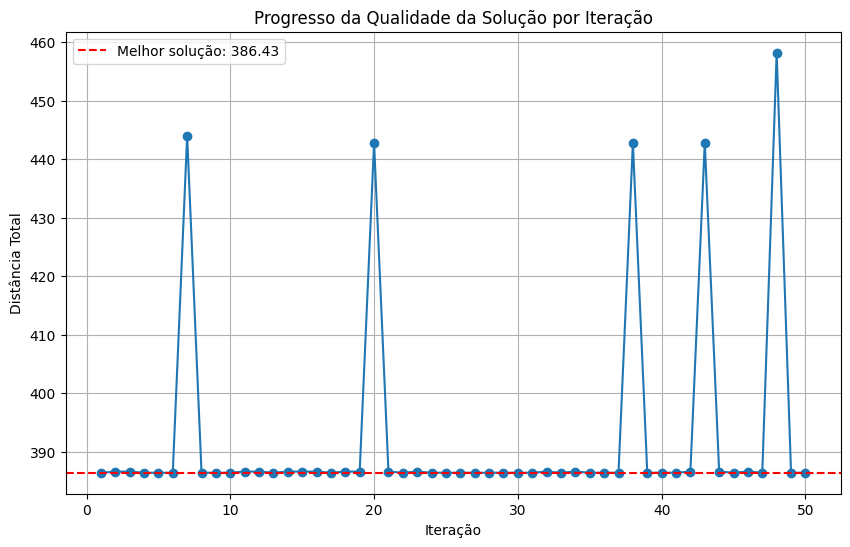

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(iteration_costs) + 1), iteration_costs, marker='o')
plt.axhline(y=best_distance, color='r', linestyle='--', label=f'Melhor solução: {best_distance:.2f}')
plt.title("Progresso da Qualidade da Solução por Iteração")
plt.xlabel("Iteração")
plt.ylabel("Distância Total")
plt.legend()
plt.grid(True)
plt.show()

## 5. Experimentos com Diferentes Parâmetros

Vamos comparar o desempenho do GRASP com diferentes valores do parâmetro alpha.

In [10]:
def experiment_with_alpha(dist_matrix: np.ndarray, alphas: List[float], max_iterations: int = 30) -> Dict:
    """
    Executa experimentos com diferentes valores de alpha.
    
    Args:
        dist_matrix: Matriz de distâncias
        alphas: Lista de valores de alpha para teste
        max_iterations: Número máximo de iterações para cada experimento
        
    Returns:
        Dicionário com resultados dos experimentos
    """
    results = {}
    
    for alpha in alphas:
        print(f"\nExperimento com alpha = {alpha}")
        
        start_time = time.time()
        best_solution, best_distance, iteration_costs = grasp_tsp(
            dist_matrix, 
            max_iterations=max_iterations, 
            alpha=alpha
        )
        execution_time = time.time() - start_time
        
        results[alpha] = {
            'best_solution': best_solution,
            'best_distance': best_distance,
            'execution_time': execution_time,
            'iteration_costs': iteration_costs
        }
        
        print(f"Melhor distância: {best_distance:.2f}")
        print(f"Tempo de execução: {execution_time:.2f} segundos")
    
    return results

# Realizar experimentos com diferentes valores de alpha
alphas = [0.0, 0.2, 0.5, 0.8, 1.0]
alpha_results = experiment_with_alpha(dist_matrix, alphas, max_iterations=30)


Experimento com alpha = 0.0
Iteração 1: Nova melhor solução com distância 386.63
Iteração 3: Nova melhor solução com distância 386.43
Melhor distância: 386.43
Tempo de execução: 0.09 segundos

Experimento com alpha = 0.2
Iteração 1: Nova melhor solução com distância 386.43
Iteração 3: Nova melhor solução com distância 386.43
Melhor distância: 386.43
Tempo de execução: 0.15 segundos

Experimento com alpha = 0.5
Iteração 1: Nova melhor solução com distância 386.43
Iteração 6: Nova melhor solução com distância 386.43
Melhor distância: 386.43
Tempo de execução: 0.25 segundos

Experimento com alpha = 0.8
Iteração 1: Nova melhor solução com distância 444.59
Iteração 2: Nova melhor solução com distância 386.43
Iteração 3: Nova melhor solução com distância 386.43
Melhor distância: 386.43
Tempo de execução: 0.24 segundos

Experimento com alpha = 1.0
Iteração 1: Nova melhor solução com distância 386.63
Iteração 2: Nova melhor solução com distância 386.43
Iteração 7: Nova melhor solução com dist

### 5.1. Comparação dos Resultados

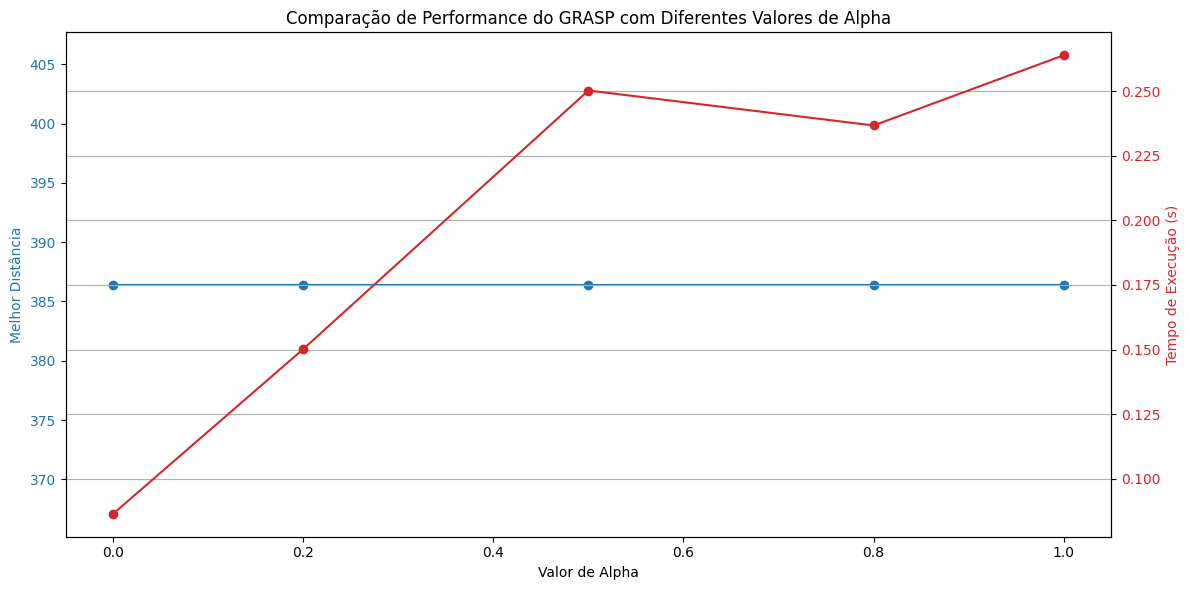

In [11]:
# Comparar os resultados com diferentes valores de alpha
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Valor de Alpha')
ax1.set_ylabel('Melhor Distância', color='tab:blue')
ax1.plot(alphas, [alpha_results[a]['best_distance'] for a in alphas], 'o-', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tempo de Execução (s)', color='tab:red')
ax2.plot(alphas, [alpha_results[a]['execution_time'] for a in alphas], 'o-', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Comparação de Performance do GRASP com Diferentes Valores de Alpha')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.2. Visualização da Melhor Solução Geral

Melhor valor de alpha: 0.2
Melhor distância geral: 386.43


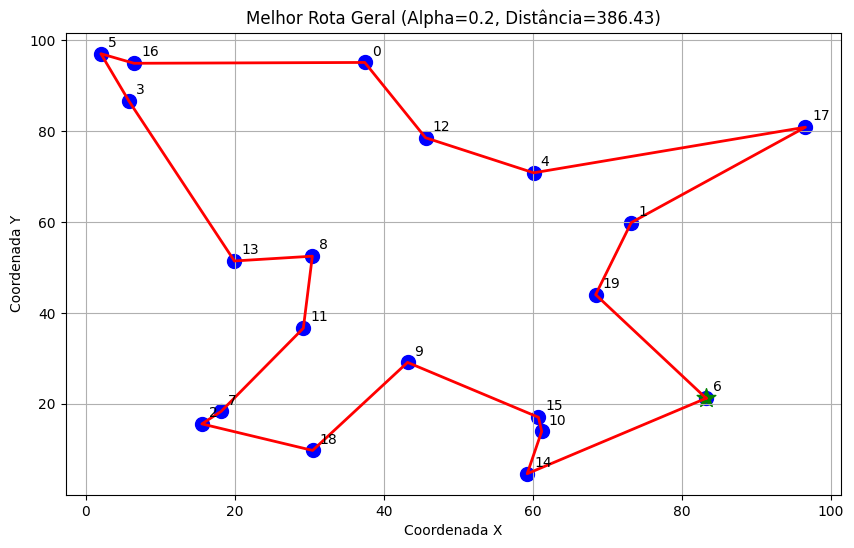

In [12]:
# Encontrar o melhor valor de alpha
best_alpha = min(alphas, key=lambda a: alpha_results[a]['best_distance'])
best_overall_solution = alpha_results[best_alpha]['best_solution']
best_overall_distance = alpha_results[best_alpha]['best_distance']

print(f"Melhor valor de alpha: {best_alpha}")
print(f"Melhor distância geral: {best_overall_distance:.2f}")

# Plotar a melhor solução geral
plot_route(cities, best_overall_solution, 
           f"Melhor Rota Geral (Alpha={best_alpha}, Distância={best_overall_distance:.2f})")

## 6. Conclusões sobre o Algoritmo GRASP

### Vantagens do GRASP:

1. **Simplicidade**: O GRASP é fácil de implementar e entender.

2. **Flexibilidade**: Pode ser adaptado para uma ampla variedade de problemas de otimização combinatória.

3. **Controle de aleatoriedade**: O parâmetro alpha permite ajustar o equilíbrio entre exploração (aleatoriedade) e intensificação (guloso).

4. **Paralelizável**: As múltiplas iterações do GRASP são independentes, permitindo implementações paralelas eficientes.

5. **Robusto**: O GRASP é menos propenso a ficar preso em ótimos locais devido à sua natureza multi-start.

### Limitações do GRASP:

1. **Dependência de parâmetros**: O desempenho do GRASP pode ser sensível à escolha do parâmetro alpha e ao número de iterações.

2. **Memória limitada**: O GRASP básico não utiliza informações de iterações anteriores para guiar a busca.

3. **Convergência lenta**: Pode requerer muitas iterações para encontrar soluções de alta qualidade em problemas complexos.

4. **Sensibilidade a parâmetros**: O desempenho depende significativamente do valor apropriado de alpha.

### Observações com base nos experimentos:

1. **Efeito do parâmetro alpha**: 
   - Alpha = 0 (puramente guloso) pode convergir rapidamente, mas frequentemente para soluções subótimas.
   - Alpha = 1 (puramente aleatório) explora mais o espaço de soluções, mas pode ser menos eficiente.
   - Valores intermediários de alpha geralmente proporcionam o melhor equilíbrio entre exploração e intensificação.

2. **Importância da busca local**: A fase de busca local é crucial para refinar as soluções construídas e atingir resultados de alta qualidade.

3. **Número de iterações**: Mais iterações geralmente levam a melhores resultados, mas com retornos decrescentes.

## 7. Conclusão

O GRASP é um algoritmo metaheurístico poderoso e versátil para resolver problemas de otimização combinatória. Suas principais vantagens são a simplicidade de implementação, o controle flexível entre aleatoriedade e guloso, e a capacidade de produzir soluções de alta qualidade para problemas complexos.

Neste notebook, implementamos o GRASP para o Problema do Caixeiro Viajante, demonstrando seu funcionamento e eficácia. 

Os experimentos realizados mostram a importância do parâmetro alpha no equilíbrio entre exploração e intensificação, e como diferentes valores podem impactar a qualidade das soluções encontradas.

Em resumo, o GRASP representa uma abordagem valiosa no arsenal de técnicas para resolver problemas de otimização combinatória quando métodos exatos não são viáveis devido à complexidade computacional.

## 10. Referências

1. Feo, T.A., Resende, M.G.C. (1995). "Greedy Randomized Adaptive Search Procedures". Journal of Global Optimization, 6, 109-133.

2. Resende, M.G.C., Ribeiro, C.C. (2010). "Greedy Randomized Adaptive Search Procedures: Advances, Hybridizations, and Applications". In: Gendreau M., Potvin JY. (eds) Handbook of Metaheuristics. International Series in Operations Research & Management Science, vol 146. Springer, Boston, MA.

3. Festa, P., Resende, M.G.C. (2009). "An annotated bibliography of GRASP – Part I: Algorithms". International Transactions in Operational Research, 16(1), 1-24.

4. Festa, P., Resende, M.G.C. (2009). "An annotated bibliography of GRASP – Part II: Applications". International Transactions in Operational Research, 16(2), 131-172.

5. Applegate, D.L., Bixby, R.E., Chvátal, V., Cook, W.J. (2006). "The Traveling Salesman Problem: A Computational Study". Princeton University Press.